Proyek UAS

Kelompok 01:
- Akmal Rabbani - 2106731610
- Cecilia Inez Reva Manurung - 2106636994
- Ryan Adidaru - 2306266994
- Sulthan Satrya Yudha Darmawan - 2106731560

In [ ]:
# Upload kaggle.json dari akun Kaggle (Profile → Account → Create API Token)
from google.colab import files
files.upload()  # Upload kaggle.json

# Setup kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI
!pip install kaggle --quiet

# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip dataset
!unzip -q chest-xray-pneumonia.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:14<00:00, 245MB/s]
100% 2.29G/2.29G [00:14<00:00, 174MB/s]


In [ ]:
import os

# Set path ke folder dataset
data_dir = "/content/chest_xray"

# Cek isi direktori
for folder in ['train', 'val', 'test']:
    path = os.path.join(data_dir, folder)
    print(f"{folder} contains {len(os.listdir(path + '/NORMAL'))} normal and {len(os.listdir(path + '/PNEUMONIA'))} pneumonia images.")


train contains 1341 normal and 3875 pneumonia images.
val contains 8 normal and 8 pneumonia images.
test contains 234 normal and 390 pneumonia images.


In [ ]:
import torch
from torchvision import transforms

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transformasi gambar: Resize, ToTensor, Normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

Using device: cpu


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Load dataset
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Label klasifikasi
class_names = train_dataset.classes
print("Kelas:", class_names)


Kelas: ['NORMAL', 'PNEUMONIA']


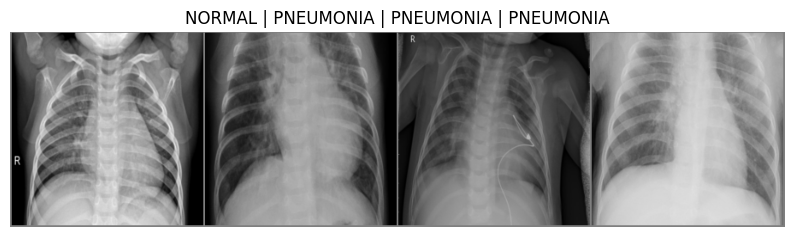

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np  # <- tambahkan ini

def imshow(img, labels):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(' | '.join(labels))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]), [class_names[i] for i in labels[:4]])


In [ ]:
from collections import Counter

def count_images_per_class(dataset, subset_name):
    class_counts = Counter([dataset.classes[label] for _, label in dataset])
    print(f"=== {subset_name.upper()} DATA ===")
    for cls, count in class_counts.items():
        print(f"{cls:10s}: {count}")
    print()

count_images_per_class(train_dataset, "train")
count_images_per_class(val_dataset, "val")
count_images_per_class(test_dataset, "test")


=== TRAIN DATA ===
NORMAL    : 1341
PNEUMONIA : 3875

=== VAL DATA ===
NORMAL    : 8
PNEUMONIA : 8

=== TEST DATA ===
NORMAL    : 234
PNEUMONIA : 390



# Cleaning

In [ ]:
from PIL import Image
import os

def validate_images(dataset):
    print("Validating images...")
    corrupted = []
    for path, _ in dataset.imgs:
        try:
            with Image.open(path) as img:
                img.verify()  # check if image is corrupted
        except Exception as e:
            corrupted.append(path)

    print(f"Corrupted images found: {len(corrupted)}")
    for path in corrupted:
        print("Removing:", path)
        os.remove(path)
    return corrupted

validate_images(train_dataset)
validate_images(val_dataset)
validate_images(test_dataset)

Validating images...
Corrupted images found: 0
Validating images...
Corrupted images found: 0
Validating images...
Corrupted images found: 0


[]

In [ ]:
def remove_extreme_size_images(dataset, min_size=(100, 100), max_size=(3000, 3000)):
    to_remove = []
    for path, _ in dataset.imgs:
        try:
            with Image.open(path) as img:
                w, h = img.size
                if w < min_size[0] or h < min_size[1] or w > max_size[0] or h > max_size[1]:
                    to_remove.append((path, (w, h)))
        except:
            continue  # skip files that cannot be opened

    print(f"{len(to_remove)} images have extreme sizes.")
    for path, size in to_remove:
        print(f"Removing {path} with size {size}")
        os.remove(path)

    return to_remove

remove_extreme_size_images(train_dataset)
remove_extreme_size_images(val_dataset)
remove_extreme_size_images(test_dataset)


0 images have extreme sizes.
0 images have extreme sizes.
0 images have extreme sizes.


[]

In [ ]:
from torchvision import datasets

# Reload ImageFolder untuk refleksikan file yang sudah dibersihkan
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples  : {len(val_dataset)}")
print(f"Test samples : {len(test_dataset)}")


Train samples: 5216
Val samples  : 16
Test samples : 624


# EDA

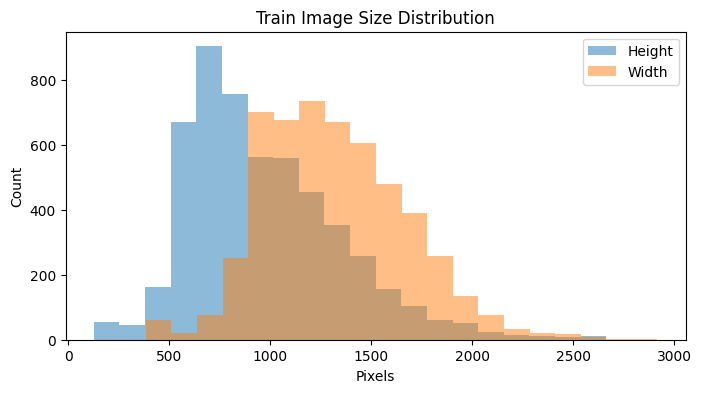

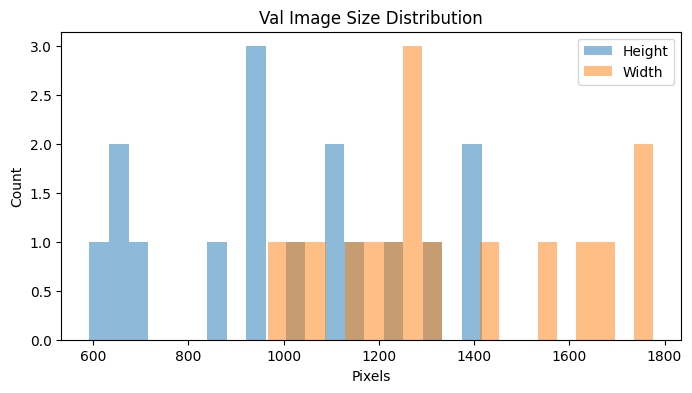

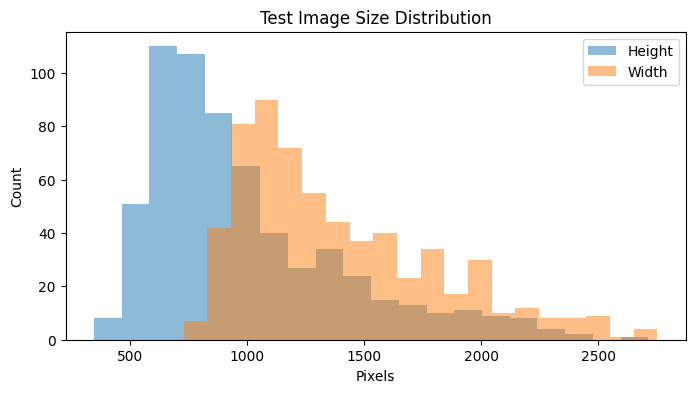

In [ ]:
import PIL

def analyze_image_dimensions(dataset, subset_name):
    heights, widths = [], []
    for img_path, _ in dataset.imgs:
        img = PIL.Image.open(img_path)
        w, h = img.size
        heights.append(h)
        widths.append(w)

    plt.figure(figsize=(8, 4))
    plt.hist(heights, bins=20, alpha=0.5, label='Height')
    plt.hist(widths, bins=20, alpha=0.5, label='Width')
    plt.title(f"{subset_name.capitalize()} Image Size Distribution")
    plt.xlabel('Pixels')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

analyze_image_dimensions(train_dataset, "train")
analyze_image_dimensions(val_dataset, "val")
analyze_image_dimensions(test_dataset, "test")

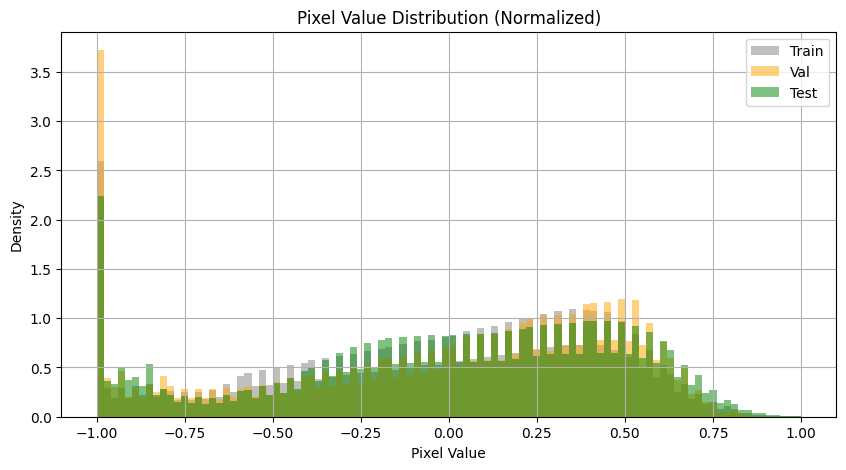

In [ ]:
def get_pixel_values(loader, max_batches=5):
    all_pixels = []
    for i, (images, _) in enumerate(loader):
        all_pixels.append(images.view(-1).numpy())
        if i >= max_batches - 1:
            break
    return np.concatenate(all_pixels)

pixels_train = get_pixel_values(train_loader)
pixels_val   = get_pixel_values(val_loader)
pixels_test  = get_pixel_values(test_loader)

plt.figure(figsize=(10, 5))
plt.hist(pixels_train, bins=100, alpha=0.5, label='Train', color='gray', density=True)
plt.hist(pixels_val,   bins=100, alpha=0.5, label='Val',   color='orange', density=True)
plt.hist(pixels_test,  bins=100, alpha=0.5, label='Test',  color='green', density=True)
plt.title('Pixel Value Distribution (Normalized)')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


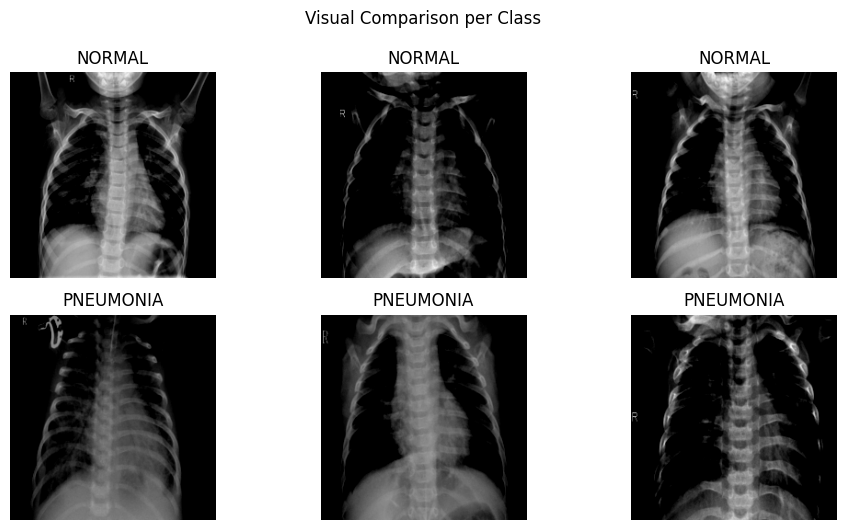

In [ ]:
def compare_classes_visual(dataset, class_names, num_per_class=3):
    fig, axes = plt.subplots(len(class_names), num_per_class, figsize=(10, 5))
    for cls_idx, cls_name in enumerate(class_names):
        shown = 0
        for img, label in dataset:
            if label == cls_idx:
                axes[cls_idx, shown].imshow(np.transpose(img.numpy(), (1, 2, 0)))
                axes[cls_idx, shown].set_title(cls_name)
                axes[cls_idx, shown].axis('off')
                shown += 1
                if shown >= num_per_class:
                    break
    plt.tight_layout()
    plt.suptitle("Visual Comparison per Class", y=1.05)
    plt.show()

compare_classes_visual(train_dataset, class_names)

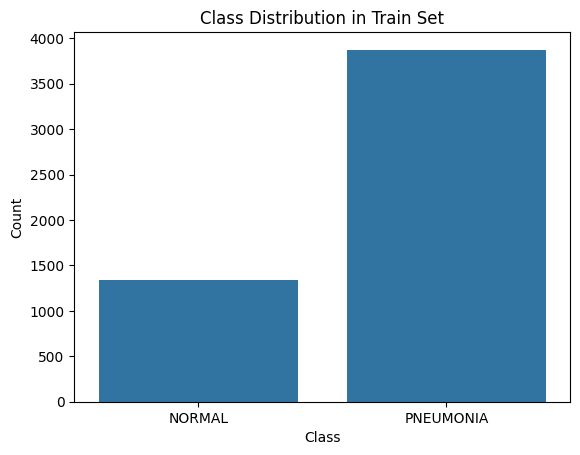

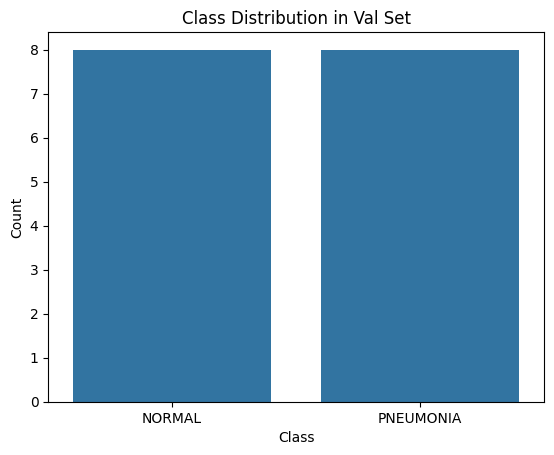

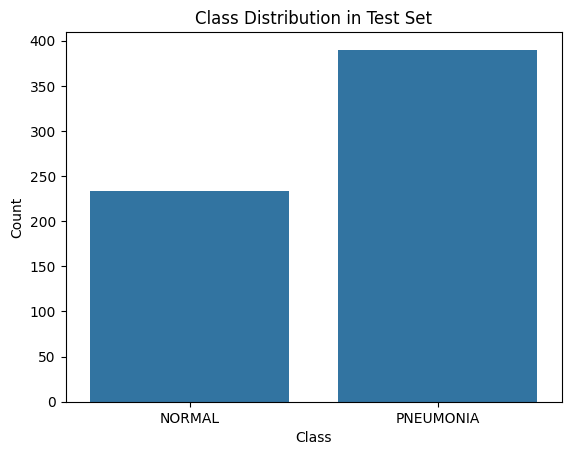

In [ ]:
import seaborn as sns
import pandas as pd

def plot_class_distribution(dataset, subset_name):
    labels = [label for _, label in dataset]
    df = pd.DataFrame({'label': labels})
    df['label'] = df['label'].map({0: class_names[0], 1: class_names[1]})

    sns.countplot(data=df, x='label')
    plt.title(f'Class Distribution in {subset_name.title()} Set')
    plt.ylabel('Count')
    plt.xlabel('Class')
    plt.show()

plot_class_distribution(train_dataset, 'train')
plot_class_distribution(val_dataset, 'val')
plot_class_distribution(test_dataset, 'test')


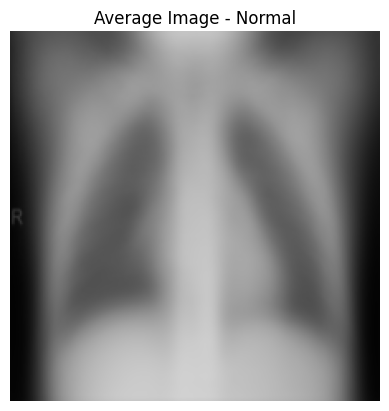

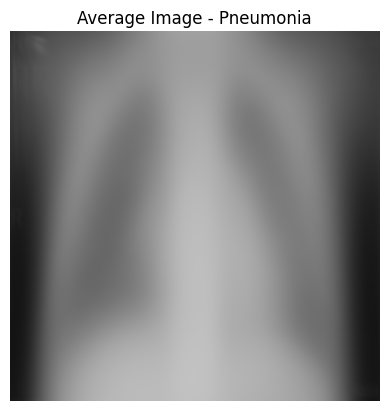

In [ ]:
def compute_average_image(dataset, label_idx):
    imgs = [img for img, lbl in dataset if lbl == label_idx]
    avg_img = torch.stack(imgs).mean(dim=0)
    return avg_img

avg_normal = compute_average_image(train_dataset, 0)
avg_pneumonia = compute_average_image(train_dataset, 1)

def show_avg_image(img_tensor, title):
    img = img_tensor / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

show_avg_image(avg_normal, 'Average Image - Normal')
show_avg_image(avg_pneumonia, 'Average Image - Pneumonia')


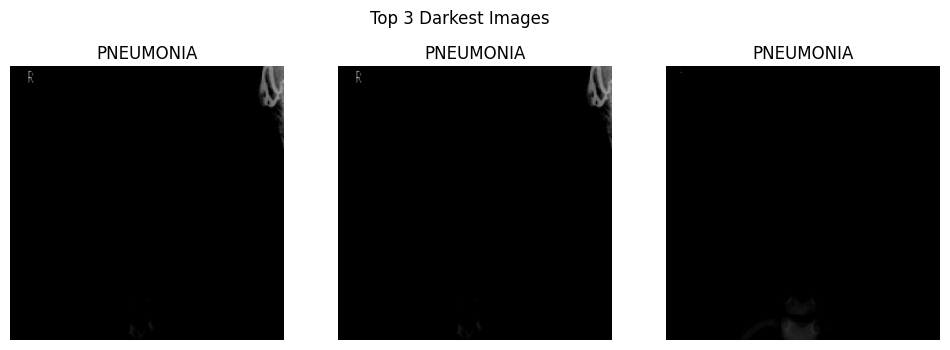

In [ ]:
def show_extreme_images(dataset, metric='brightness', top_k=3, reverse=False):
    scores = []
    for i, (img, label) in enumerate(dataset):
        img_np = img.numpy()
        brightness = img_np.mean()
        scores.append((brightness, i))

    scores.sort(reverse=reverse)
    fig, axes = plt.subplots(1, top_k, figsize=(12, 4))
    for idx, (_, i) in enumerate(scores[:top_k]):
        img, label = dataset[i]
        axes[idx].imshow(np.transpose(img.numpy(), (1, 2, 0)), cmap='gray')
        axes[idx].set_title(f"{class_names[label]}")
        axes[idx].axis('off')
    plt.suptitle(f'Top {top_k} {"Brightest" if reverse else "Darkest"} Images')
    plt.show()

show_extreme_images(train_dataset, metric='brightness', reverse=False)


In [ ]:
def compute_brightness_list(dataset, max_images=None):
    brightness_scores = []
    for i, (img, _) in enumerate(dataset):
        brightness = img.numpy().mean()
        brightness_scores.append(brightness)
        if max_images and i >= max_images:
            break
    return brightness_scores

# Hitung brightness untuk semua dataset
brightness_train = compute_brightness_list(train_dataset)
brightness_val   = compute_brightness_list(val_dataset)
brightness_test  = compute_brightness_list(test_dataset)


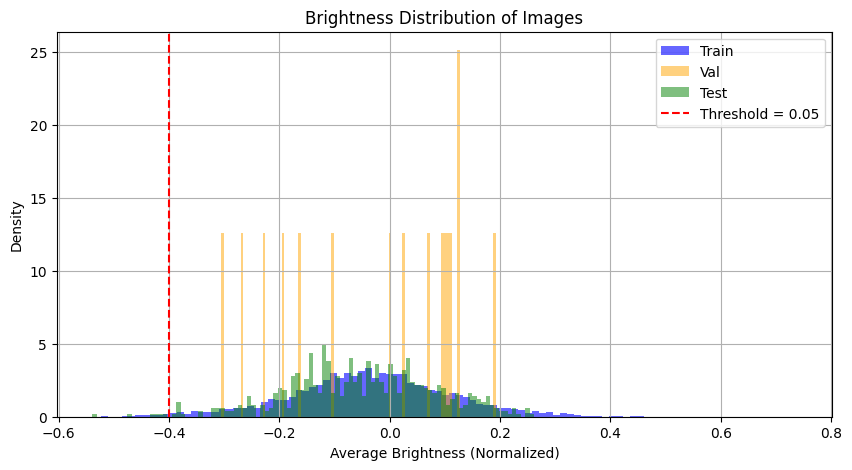

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(brightness_train, bins=100, alpha=0.6, label='Train', color='blue', density=True)
plt.hist(brightness_val, bins=100, alpha=0.5, label='Val', color='orange', density=True)
plt.hist(brightness_test, bins=100, alpha=0.5, label='Test', color='green', density=True)
plt.axvline(-0.4, color='red', linestyle='--', label='Threshold = 0.05')
plt.title("Brightness Distribution of Images")
plt.xlabel("Average Brightness (Normalized)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def remove_very_dark_images(dataset, threshold=-0.4):
    to_remove = []
    for i, (img, label) in enumerate(dataset):
        brightness = img.numpy().mean()
        if brightness < threshold:
            img_path, _ = dataset.samples[i]
            to_remove.append((img_path, brightness))

    print(f"Found {len(to_remove)} images with brightness < {threshold}")
    for path, brightness in to_remove:
        print(f"Removing {path} (brightness={brightness:.4f})")
        os.remove(path)

    return to_remove

# Jalankan untuk semua subset (train, val, test)
removed_dark_train = remove_very_dark_images(train_dataset, threshold=-0.4)
removed_dark_val   = remove_very_dark_images(val_dataset, threshold=-0.4)
removed_dark_test  = remove_very_dark_images(test_dataset, threshold=-0.4)

Found 48 images with brightness < -0.4
Removing /content/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg (brightness=-0.4251)
Removing /content/chest_xray/train/PNEUMONIA/person101_virus_188.jpeg (brightness=-0.4235)
Removing /content/chest_xray/train/PNEUMONIA/person1180_virus_2007.jpeg (brightness=-0.4142)
Removing /content/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg (brightness=-0.4119)
Removing /content/chest_xray/train/PNEUMONIA/person1419_bacteria_3645.jpeg (brightness=-0.4400)
Removing /content/chest_xray/train/PNEUMONIA/person1488_virus_2587.jpeg (brightness=-0.4024)
Removing /content/chest_xray/train/PNEUMONIA/person1585_bacteria_4149.jpeg (brightness=-0.4182)
Removing /content/chest_xray/train/PNEUMONIA/person1667_bacteria_4418.jpeg (brightness=-0.4271)
Removing /content/chest_xray/train/PNEUMONIA/person1679_bacteria_4453.jpeg (brightness=-0.4498)
Removing /content/chest_xray/train/PNEUMONIA/person276_virus_569.jpeg (brightness=-0.4420)
Removing /content/chest_xra

In [ ]:
# Hitung jumlah total file sebelum reload
def count_images_in_folder(folder_path):
    total = 0
    for class_dir in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_dir)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

train_count_after = count_images_in_folder(os.path.join(data_dir, 'train'))
val_count_after   = count_images_in_folder(os.path.join(data_dir, 'val'))
test_count_after  = count_images_in_folder(os.path.join(data_dir, 'test'))

print("=== Total Images AFTER Removing Dark Images ===")
print(f"Train : {train_count_after} images")
print(f"Val   : {val_count_after} images")
print(f"Test  : {test_count_after} images")

# Tampilkan juga jumlah yang dihapus jika sebelumnya sudah dihitung
print("\n=== Images Removed Due to Brightness < -0.45 ===")
print(f"Train : {len(removed_dark_train)} removed")
print(f"Val   : {len(removed_dark_val)} removed")
print(f"Test  : {len(removed_dark_test)} removed")

=== Total Images AFTER Removing Dark Images ===
Train : 5168 images
Val   : 16 images
Test  : 618 images

=== Images Removed Due to Brightness < -0.45 ===
Train : 48 removed
Val   : 0 removed
Test  : 6 removed


In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

# Feature Extraction

In [ ]:
import torch.nn as nn
from torchvision import models

# Load ResNet18 pretrained dan buang FC layer-nya
resnet = models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # exclude final FC layer
feature_extractor.eval().to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs)
            feats = feats.view(feats.size(0), -1)  # flatten dari [B, 512, 1, 1] ke [B, 512]
            features.append(feats.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X_train, y_train = extract_features(train_loader)
X_val, y_val     = extract_features(val_loader)
X_test, y_test   = extract_features(test_loader)

print("Train features shape:", X_train.shape)
print("Validation features shape:", X_val.shape)
print("Test features shape:", X_test.shape)

Train features shape: torch.Size([5168, 512])
Validation features shape: torch.Size([16, 512])
Test features shape: torch.Size([618, 512])


# ANN (Multilayer Perceptron Training)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)  # binary classification
        )

    def forward(self, x):
        return self.fc(x)

model = MLP(input_dim=512).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Pindahkan X dan y ke device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_val   = X_val.to(device)
y_val   = y_val.to(device)

In [ ]:
def train_mlp(model, X_train, y_train, X_val, y_val, epochs=2000):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_preds = torch.argmax(val_outputs, dim=1)
            acc = (val_preds == y_val).float().mean()

        print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Val Acc: {acc.item():.4f}")

train_mlp(model, X_train, y_train, X_val, y_val)


Epoch 1/2000 | Loss: 0.0528 | Val Acc: 0.8125
Epoch 2/2000 | Loss: 0.0531 | Val Acc: 0.8125
Epoch 3/2000 | Loss: 0.0527 | Val Acc: 0.8125
Epoch 4/2000 | Loss: 0.0528 | Val Acc: 0.8125
Epoch 5/2000 | Loss: 0.0512 | Val Acc: 0.8125
Epoch 6/2000 | Loss: 0.0511 | Val Acc: 0.8125
Epoch 7/2000 | Loss: 0.0514 | Val Acc: 0.8125
Epoch 8/2000 | Loss: 0.0521 | Val Acc: 0.8125
Epoch 9/2000 | Loss: 0.0512 | Val Acc: 0.8125
Epoch 10/2000 | Loss: 0.0489 | Val Acc: 0.8125
Epoch 11/2000 | Loss: 0.0513 | Val Acc: 0.8125
Epoch 12/2000 | Loss: 0.0505 | Val Acc: 0.8125
Epoch 13/2000 | Loss: 0.0512 | Val Acc: 0.8125
Epoch 14/2000 | Loss: 0.0518 | Val Acc: 0.8125
Epoch 15/2000 | Loss: 0.0499 | Val Acc: 0.8125
Epoch 16/2000 | Loss: 0.0480 | Val Acc: 0.8125
Epoch 17/2000 | Loss: 0.0486 | Val Acc: 0.8125
Epoch 18/2000 | Loss: 0.0499 | Val Acc: 0.8125
Epoch 19/2000 | Loss: 0.0485 | Val Acc: 0.8125
Epoch 20/2000 | Loss: 0.0485 | Val Acc: 0.8125
Epoch 21/2000 | Loss: 0.0497 | Val Acc: 0.8125
Epoch 22/2000 | Loss: 

              precision    recall  f1-score   support

      NORMAL       0.96      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.86       384

    accuracy                           0.80       618
   macro avg       0.86      0.75      0.76       618
weighted avg       0.84      0.80      0.79       618



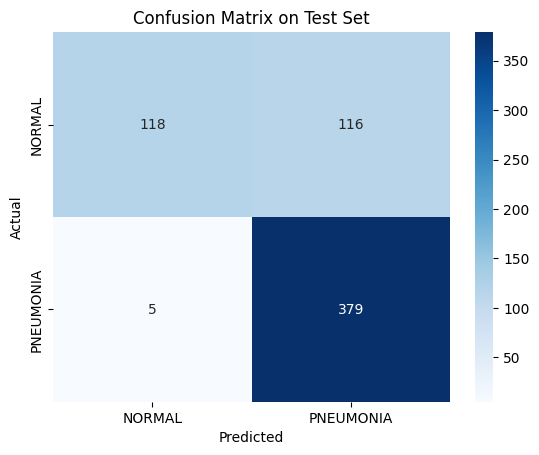

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device))
    y_pred = torch.argmax(y_pred, dim=1).cpu()

print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset_tensor = TensorDataset(X_train.cpu(), y_train.cpu())
val_dataset_tensor   = TensorDataset(X_val.cpu(), y_val.cpu())
test_dataset_tensor  = TensorDataset(X_test.cpu(), y_test.cpu())

train_loader = DataLoader(train_dataset_tensor, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset_tensor, batch_size=batch_size)
test_loader  = DataLoader(test_dataset_tensor, batch_size=batch_size)

In [ ]:
def train_mlp_with_earlystop(model, train_loader, val_loader, epochs=50, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0

    train_losses, val_accuracies, train_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == yb).sum().item()
            total_train += yb.size(0)

        avg_loss = running_loss / len(train_loader)
        acc_train = correct_train / total_train
        train_losses.append(avg_loss)
        train_accuracies.append(acc_train)

        # validation
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == yb).sum().item()
                total_val += yb.size(0)

        acc_val = correct_val / total_val
        val_accuracies.append(acc_val)

        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f} | Train Acc={acc_train:.4f} | Val Acc={acc_val:.4f}")

        if acc_val > best_acc:
            best_acc = acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_accuracies


In [ ]:
model = MLP(input_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

model, losses, train_accs, val_accs = train_mlp_with_earlystop(model, train_loader, val_loader)


Epoch 1: Loss=0.2063 | Train Acc=0.9189 | Val Acc=0.8125
Epoch 2: Loss=0.1140 | Train Acc=0.9582 | Val Acc=0.8125
Epoch 3: Loss=0.0939 | Train Acc=0.9667 | Val Acc=0.8750
Epoch 4: Loss=0.0958 | Train Acc=0.9625 | Val Acc=0.6250
Epoch 5: Loss=0.0775 | Train Acc=0.9700 | Val Acc=0.8125
Epoch 6: Loss=0.0680 | Train Acc=0.9735 | Val Acc=0.9375
Epoch 7: Loss=0.0649 | Train Acc=0.9745 | Val Acc=0.7500
Epoch 8: Loss=0.0692 | Train Acc=0.9743 | Val Acc=0.7500
Epoch 9: Loss=0.0633 | Train Acc=0.9758 | Val Acc=0.8125
Epoch 10: Loss=0.0592 | Train Acc=0.9762 | Val Acc=0.6250
Epoch 11: Loss=0.0557 | Train Acc=0.9787 | Val Acc=0.9375
Early stopping triggered.


In [ ]:
# Test accuracy (satu kali hitung setelah training selesai)
model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = torch.argmax(outputs, dim=1)
        correct_test += (preds == yb).sum().item()
        total_test += yb.size(0)

test_accuracy = correct_test / total_test
print(f"Final Test Accuracy: {test_accuracy:.4f}")

Final Test Accuracy: 0.8317


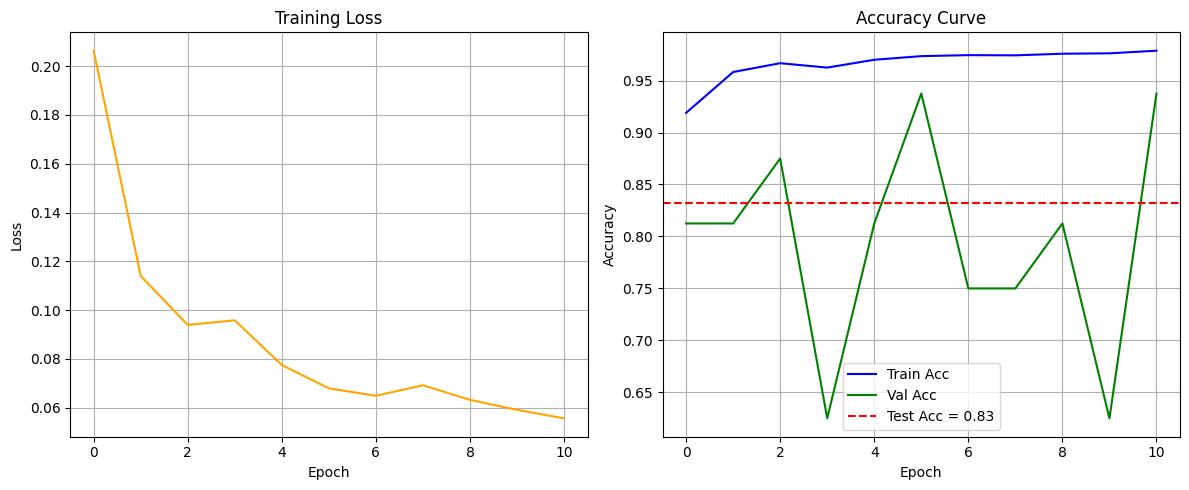

In [ ]:
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(losses, label='Train Loss', color='orange')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc', color='blue')
plt.plot(val_accs, label='Val Acc', color='green')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Acc = {test_accuracy:.2f}')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()